<a href="https://colab.research.google.com/github/iimmuunnee/SolarX/blob/main/SolarX_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [20]:
import pandas as pd
import numpy as np
import os

# 1. 깃허브 저장소 복제 (SolarX)
!git clone https://github.com/iimmuunnee/SolarX

# 2. 폴더 이동
os.chdir('SolarX')
print(f">>> 현재 경로: {os.getcwd()}")
print(f">>> 파일 목록: {os.listdir()}")

# 3. 파일 바로 읽어오기
# 파일명이 길거나 달라도 키워드로 찾아서 자동으로 읽습니다.
weather_list = []
solar_df = None

print("\n>>> 파일 로드 및 분류 중...")
for filename in os.listdir():
    if not filename.endswith('.csv'): continue # csv 파일만 봄

    # 한글 깨짐 방지 로딩
    try:
        df = pd.read_csv(filename, encoding='cp949')
    except:
        df = pd.read_csv(filename, encoding='utf-8')

    # 내용 보고 분류
    if '기온(°C)' in df.columns:
        weather_list.append(df)
        print(f"날씨 데이터 확인: {filename}")
    elif '01시' in df.columns:
        solar_df = df
        print(f"발전량 데이터 확인: {filename}")

# 4. 날씨 데이터 합치기
if len(weather_list) >= 2:
    weather_df = pd.concat(weather_list, ignore_index=True)
    weather_df['일시'] = pd.to_datetime(weather_df['일시'])
    weather_df = weather_df.sort_values('일시').reset_index(drop=True)
elif len(weather_list) == 1:
    weather_df = weather_list[0]
else:
    print("Error: 날씨 데이터가 없습니다! 깃허브에 파일이 있는지 확인하세요.")

# 5. 발전량 데이터 전처리 (가로 -> 세로)
if solar_df is not None:
    solar_melted = solar_df.melt(id_vars=['날짜'],
                                value_vars=[f'{i:02d}시' for i in range(1, 25)],
                                var_name='시간_str',
                                value_name='발전량')
    solar_melted['Hour'] = solar_melted['시간_str'].str.replace('시', '').astype(int)
    solar_melted['Date'] = pd.to_datetime(solar_melted['날짜'])
    solar_melted['Hour'] = solar_melted['Hour'] - 1
    solar_melted['Datetime'] = solar_melted['Date'] + pd.to_timedelta(solar_melted['Hour'], unit='h')

    # 6. 최종 병합
    weather_df['Datetime'] = pd.to_datetime(weather_df['일시'])
    weather_selected = weather_df[['Datetime', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)']].copy()
    weather_selected = weather_selected.fillna(0)

    final_data = pd.merge(weather_selected, solar_melted[['Datetime', '발전량']], on='Datetime', how='inner')

    print("\n[Success] 데이터 준비 완료!")
    print(f"총 데이터 개수: {len(final_data)}개")
else:
    print("Error: 발전량 데이터가 없습니다!")

Cloning into 'SolarX'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 315.99 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.
>>> 현재 경로: /content/SolarX/SolarX/SolarX
>>> 파일 목록: ['README.md', '.git', '한국동서발전(주)_동해바이오연료저장고지붕태양광발전_시간대별_발전량_20250630.csv', 'SolarX_v1.ipynb', '기상청240101_240629(전반기).csv', '기상청240630_250630(후반기).csv']

>>> 파일 로드 및 분류 중...
발전량 데이터 확인: 한국동서발전(주)_동해바이오연료저장고지붕태양광발전_시간대별_발전량_20250630.csv
날씨 데이터 확인: 기상청240101_240629(전반기).csv
날씨 데이터 확인: 기상청240630_250630(후반기).csv

[Success] 데이터 준비 완료!
총 데이터 개수: 13080개


# 데이터 전처리

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [22]:
# 1. 데이터 준비 (입력값 X, 정답값 y)
print(">>> 데이터 전처리 중...")

# 사용할 특징(Feature) 선택: 날씨 7개 + 과거 발전량 1개 = 총 8개
feature_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '발전량']
label_col = ['발전량']

# 데이터 정규화 Min-Max 스케일링 (0~1 사이로 압축)
# 입력(X)과 정답(y)의 스케일러를 따로 생성
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# 입력 데이터 정규화
data_x = scaler_x.fit_transform(final_data[feature_cols])
# 정답 데이터 정규화 (나중에 그래프 그릴 때 원래 값으로 복구하기 위해 따로 둠)
data_y = scaler_y.fit_transform(final_data[label_col])

# 시계열 데이터셋 만들기 (과거 24시간 데이터를 보고 -> 다음 1시간 예측)
def create_sequences(data_x, data_y, seq_length=24):
    xs, ys = [], []
    for i in range(len(data_x) - seq_length):
        x = data_x[i:i+seq_length]
        y = data_y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
X, y = create_sequences(data_x, data_y, SEQ_LENGTH)

# 텐서(Tensor)로 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 학습용(Train) / 검증용(Test) 나누기 (80% 학습, 20% 시험)
train_size = int(len(X) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

print(f"학습 데이터: {len(X_train)}개, 테스트 데이터: {len(X_test)}개")

>>> 데이터 전처리 중...
학습 데이터: 10444개, 테스트 데이터: 2612개


# LSTM 모델 설계

In [23]:
# 2. LSTM 모델 설계 (입력 8개 -> 출력 1개)
class SolarLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SolarLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 층
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 결과 출력 층
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 은닉 상태(h0)와 셀 상태(c0)를 0으로 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        # 마지막 시간대의 결과만 사용
        out = self.fc(out[:, -1, :])
        return out

# 모델 생성 (입력=8개, 은닉층=64개, 출력=1개)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

model = SolarLSTM(input_size=8, hidden_size=64, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

사용 장치: cuda


# 모델 학습

In [24]:
# 3. 학습 시작 (Training)
print("\n>>> 학습 시작! (Loss가 줄어드는지 확인하세요)")
num_epochs = 100
batch_size = 64

# 데이터 로더 (배치 단위로 학습)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")


>>> 학습 시작! (Loss가 줄어드는지 확인하세요)
Epoch [10/100], Loss: 0.003015
Epoch [20/100], Loss: 0.002798
Epoch [30/100], Loss: 0.002722
Epoch [40/100], Loss: 0.002663
Epoch [50/100], Loss: 0.002555
Epoch [60/100], Loss: 0.002442
Epoch [70/100], Loss: 0.002379
Epoch [80/100], Loss: 0.002266
Epoch [90/100], Loss: 0.002153
Epoch [100/100], Loss: 0.001982


# 학습 결과 확인


>>> 예측 결과 그리는 중...


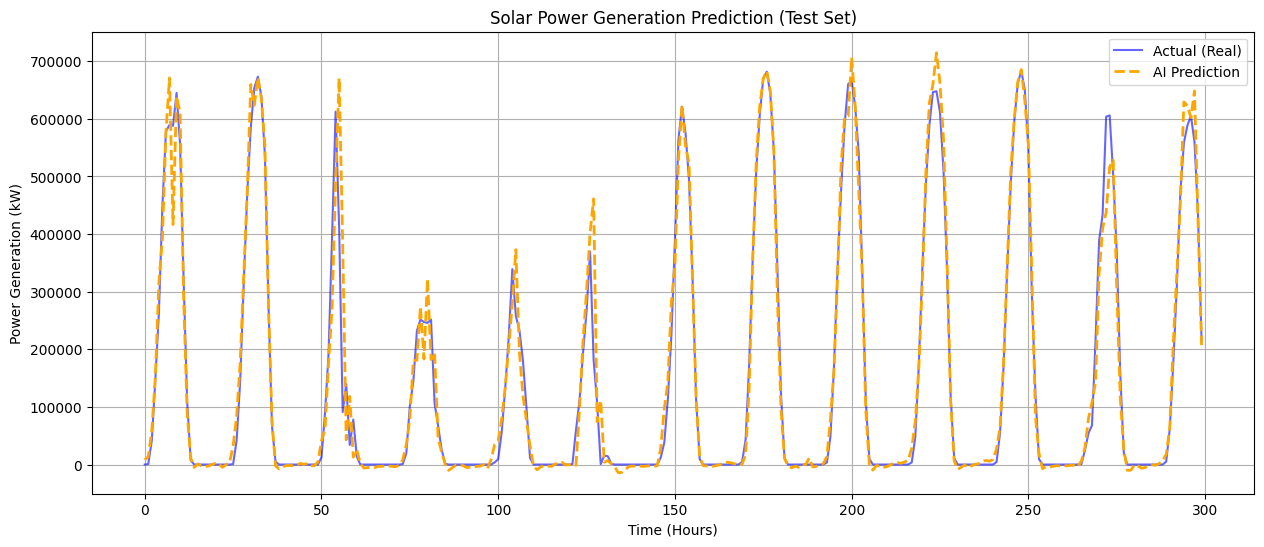


📊 모델 정확도 (R2 Score): 0.9389 (1.0에 가까울수록 완벽)


In [25]:
# 4. 결과 확인 (그래프 그리기)
print("\n>>> 예측 결과 그리는 중...")
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    test_predict = model(X_test).cpu().numpy()
    y_test_real = y_test.numpy()

# 정규화 풀고 원본 데이터 단위로
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_real_inv = scaler_y.inverse_transform(y_test_real)

# 그래프 그리기 (너무 길어서 앞부분 300시간=약 12일치만 확대해서 그림)
plt.figure(figsize=(15, 6))
plt.plot(y_test_real_inv[:300], label='Actual (Real)', color='blue', alpha=0.6)
plt.plot(test_predict_inv[:300], label='AI Prediction', color='orange', linestyle='--', linewidth=2)
plt.title('Solar Power Generation Prediction (Test Set)')
plt.xlabel('Time (Hours)')
plt.ylabel('Power Generation (kW)')
plt.legend()
plt.grid(True)
plt.show()

# 전체 구간에 대한 R2 Score (정확도 점수)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_real_inv, test_predict_inv)
print(f"\n📊 모델 정확도 (R2 Score): {r2:.4f} (1.0에 가까울수록 완벽)")

# AI 모델 기반 태양광 발전량 예측 및 ESS 최적 제어

>>> 데이터 단위 변환 완료!
   - 최대 발전량: 760.04 kW
   - 평균 발전량: 170.89 kW

>>> 7일간 수익률 분석 시작 (단위: kW 적용됨)...


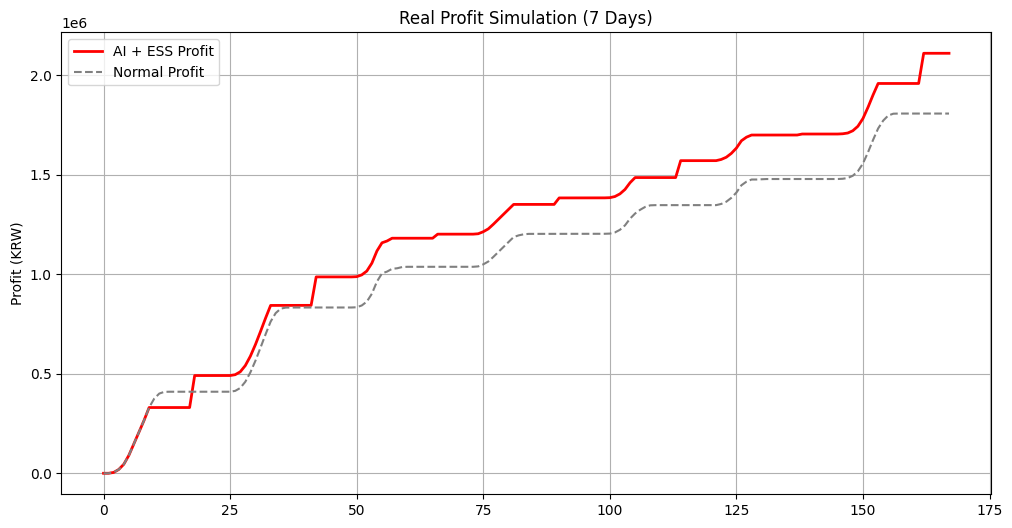

💰 [최종] 결과 발표 💰
1. 그냥 팔았을 때: 1,807,402원
2. AI 배터리 수익: 2,110,242원
🚀 수익 개선율: +16.76% !!


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 단위 보정 (Wh -> kW)
# 원본 데이터가 Wh 단위라서 1000으로 나눠야 kW
y_real_kw = y_test_real_inv / 1000
predict_kw = test_predict_inv / 1000

print(f">>> 데이터 단위 변환 완료!")
print(f"   - 최대 발전량: {np.max(y_real_kw):.2f} kW")
print(f"   - 평균 발전량: {np.mean(y_real_kw):.2f} kW")

# 2. ESS(배터리) 엔진
class Battery:
    def __init__(self, capacity, efficiency=0.9):
        self.capacity = capacity
        self.current = 0
        self.efficiency = efficiency

    def update(self, action, amount):
        # 리턴값: 배터리가 '먹거나(음수)' '뱉어낸(양수)' 전력량
        change = 0
        if action == 1: # 충전 시도
            space = self.capacity - self.current
            charge_amount = min(amount, space) # 빈 공간만큼만 충전
            self.current += charge_amount * self.efficiency
            change = -charge_amount # (이만큼은 판매 못 함)

        elif action == -1: # 방전 시도
            discharge_amount = min(self.current, self.capacity * 0.5)
            self.current -= discharge_amount
            change = discharge_amount * self.efficiency # (이만큼 추가 판매)

        return change

# 3. 시뮬레이션 설정
# 배터리 크기: 최대 발전량의 3배
battery_capacity = np.max(y_real_kw) * 3
ess = Battery(capacity=battery_capacity)

# 가격표 (Time-of-Use)
prices = []
for h in range(len(predict_kw)):
    hour = h % 24
    if 18 <= hour <= 22: prices.append(200) # 저녁 (비쌈)
    elif 10 <= hour <= 16: prices.append(80)  # 낮 (쌈)
    else: prices.append(100) # 평소

# 4. 시뮬레이션 시작
sim_days = 7
sim_hours = sim_days * 24

profit_ai = 0
profit_none = 0
history_ai = []
history_none = []

print(f"\n>>> {sim_days}일간 수익률 분석 시작 (단위: kW 적용됨)...")

for t in range(sim_hours):
    actual_gen = y_real_kw[t][0]   # 실제 (kW)
    predicted_gen = predict_kw[t][0] # 예측 (kW)
    price = prices[t]
    hour = t % 24

    # [비교군] 그냥 팔기
    profit_none += actual_gen * price
    history_none.append(profit_none)

    # [AI 모델] 전략 수립
    action = 0

    # 전략: 저녁엔 팔고, 낮엔 충전한다.
    if 18 <= hour <= 22:
        action = -1 # 방전 (비싸니까 털자)
    elif 10 <= hour <= 16:
        # 내일도 발전이 잘 될 것 같으면(예측값 > 0) 충전!
        if predicted_gen > 0.1:
            action = 1 # 충전 (싸니까 담자)

    # battery_change: 배터리에 들어간 양(음수) or 나온 양(양수)
    battery_change = ess.update(action, actual_gen)

    # 최종 판매량 = (내가 만든 거) + (배터리에서 나온 거 or 들어간 거)
    # 예: 발전 100, 충전 30 -> 판매 70
    # 예: 발전 0, 방전 50 -> 판매 50
    trade_amount = actual_gen + battery_change

    # 혹시라도 계산 오차로 음수가 되면 0으로 보정
    if trade_amount < 0: trade_amount = 0

    profit_ai += trade_amount * price
    history_ai.append(profit_ai)

# 5. 결과 발표
plt.figure(figsize=(12, 6))
plt.plot(history_ai, label='AI + ESS Profit', color='red', linewidth=2)
plt.plot(history_none, label='Normal Profit', color='gray', linestyle='--')
plt.title(f'Real Profit Simulation ({sim_days} Days)')
plt.ylabel('Profit (KRW)')
plt.legend()
plt.grid(True)
plt.show()

final_ai = history_ai[-1]
final_none = history_none[-1]
imp = ((final_ai - final_none) / final_none) * 100

print(f"💰 [최종] 결과 발표 💰")
print(f"1. 그냥 팔았을 때: {int(final_none):,}원")
print(f"2. AI 배터리 수익: {int(final_ai):,}원")
print(f"🚀 수익 개선율: {imp:+.2f}% !!")